In [1]:
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from typing import Any

import fiftyone as fo

In [2]:
coco_root = Path("/home/dherrera/data/coco")
zoo_elephants_root = Path("/home/dherrera/data/elephants/training_data")

In [3]:
fo.delete_non_persistent_datasets()
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=zoo_elephants_root,
    labels_path=zoo_elephants_root/"annotations.json",
    name="zoo-elephants",
)
print(dataset)

 100% |█████████████████| 272/272 [764.7ms elapsed, 0s remaining, 356.2 samples/s]      
Name:        zoo-elephants
Media type:  image
Num samples: 272
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [4]:
# dataset = fo.Dataset.from_dir(
#     dataset_type=fo.types.COCODetectionDataset,
#     data_path="/home/dherrera/data/coco/train2017",
#     labels_path=root/"/home/dherrera/data/coco/annotations/instances_train2017.json",
#     name="coco-train2017",
# )
# print(dataset)


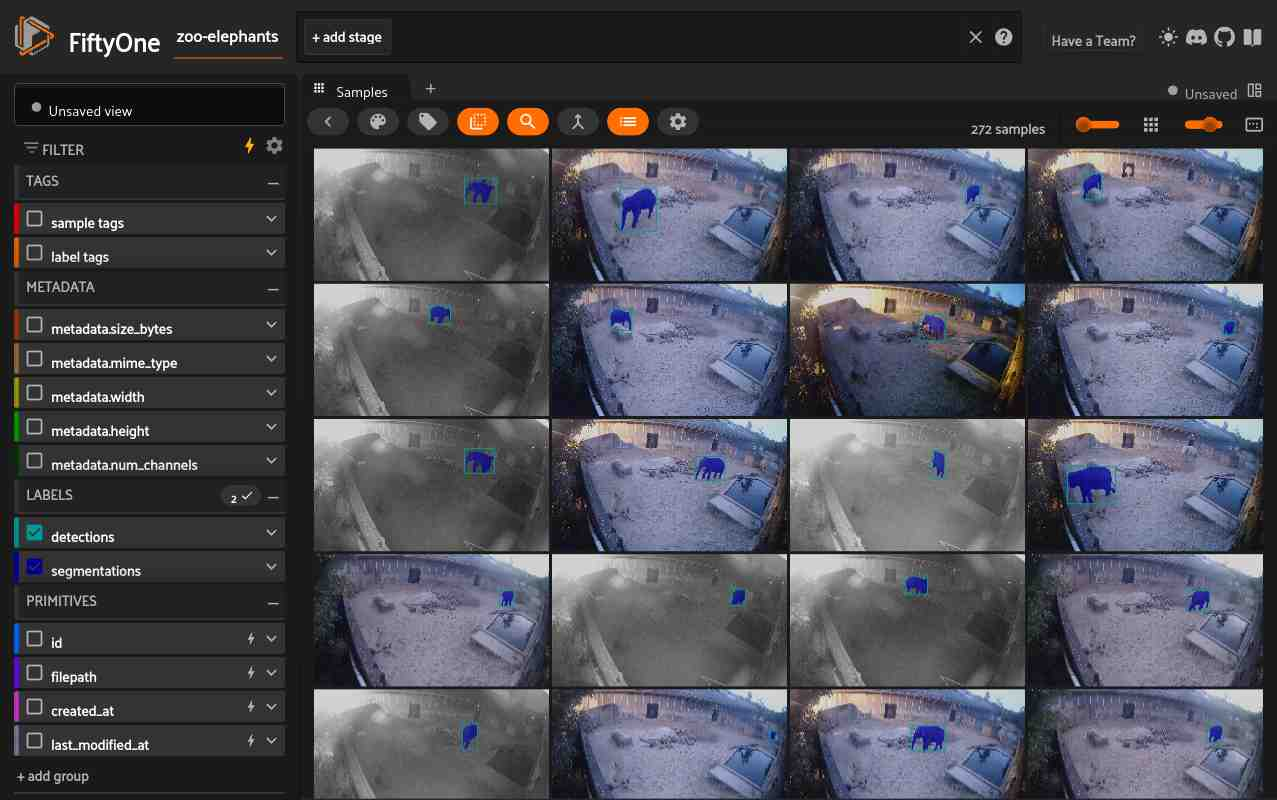

In [ ]:
ds_zoo_elephants = fo.load_dataset("zoo-elephants")
session = fo.launch_app(ds_zoo_elephants)

In [9]:
import torchvision  

print("Loading empty model...")
model = torchvision.models.get_model(
        "maskrcnn_resnet50_fpn_v2",
        weights=None,
        weights_backbone=None,
        num_classes=91,
    )

print("Loading weights from disk...")
checkpoint = torch.load("/home/dherrera/Downloads/train_output/model_19.pth", weights_only=False)
checkpoint.keys()

print("Restoring weights...")
model.load_state_dict(checkpoint["model"])
model.eval()
model

Loading empty model...
Loading weights from disk...
Restoring weights...


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [11]:
import fiftyone.utils.torch as fout

weights = torchvision.models.get_weight("MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1")
transforms = weights.transforms()

config = fout.TorchImageModelConfig(
    {
        "entrypoint_fcn": lambda: model,
        "entrypoint_args": {},
        "output_processor_cls": "fiftyone.utils.torch.InstanceSegmenterOutputProcessor",
        "classes": [f"Class {i}" for i in range(91)],
        "transforms": transforms,
        "image_min_dim": 224,
        "image_max_dim": 2048,
    }
)
fo_model = fout.TorchImageModel(config)

predictions_view = ds_zoo_elephants.take(100, seed=51)
predictions_view.apply_model(fo_model, label_field="zoo maskrcnn")
# high_conf_view = predictions_view.filter_labels("zoo maskrcnn", fo.ViewField("confidence") > 0.85, only_matches=False)

session.view = predictions_view

 100% |█████████████████| 100/100 [7.2s elapsed, 0s remaining, 14.4 samples/s]      
